In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# Libraries
import cv2
import datetime
import gc
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage.morphology
import sys
import tensorflow as tf
import tifffile

In [16]:
#Parameters
base_path = '../input/hubmap-kidney-segmentation'

plot_full_image = True

# Number of glomeruli to display for each image
num_glom_display = 5

# Number of glomberuli to save as tiff files.
num_glom_save = 5

glob_scale = 0.25

In [17]:
# Utility Functions
def rle_to_image(rle_mask, image_shape):
    """
    Converts an rle string to an image represented as a numpy array.
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

    :param rle_mask: string with rle mask.
    :param image_shape: (width, height) of array to return
    :return: Image as a numpy array. 1 = mask, 0 = background.
    """

    # Processing
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    image = np.zeros(image_shape[0] * image_shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        image[lo:hi] = 1

    return image.reshape(image_shape).T

In [18]:
#Directory Contents
# print('\n'.join(os.listdir(base_path)))
print (os.listdir(base_path))

['sample_submission.csv', 'HuBMAP-20-dataset_information.csv', 'train.csv', 'test', 'train']


In [19]:
# Training Images
train_files = sorted(glob.glob(os.path.join(base_path, 'train/*.tiff')))
print(f'Number of training images: {len(train_files)}')
print('\n'.join(train_files))

Number of training images: 15
../input/hubmap-kidney-segmentation/train/0486052bb.tiff
../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff
../input/hubmap-kidney-segmentation/train/1e2425f28.tiff
../input/hubmap-kidney-segmentation/train/26dc41664.tiff
../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
../input/hubmap-kidney-segmentation/train/4ef6695ce.tiff
../input/hubmap-kidney-segmentation/train/54f2eec69.tiff
../input/hubmap-kidney-segmentation/train/8242609fa.tiff
../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
../input/hubmap-kidney-segmentation/train/afa5e8098.tiff
../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff
../input/hubmap-kidney-segmentation/train/b9a3865fc.tiff
../input/hubmap-kidney-segmentation/train/c68fe75ea.tiff
../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
../input/hubmap-kidney-segmentation/train/e79de561c.tiff


In [20]:
#Test Images
test_files = sorted(glob.glob(os.path.join(base_path, 'test/*.tiff')))
print(f'Number of test images: {len(test_files)}')
print('\n'.join(test_files))

Number of test images: 5
../input/hubmap-kidney-segmentation/test/2ec3f1bb9.tiff
../input/hubmap-kidney-segmentation/test/3589adb90.tiff
../input/hubmap-kidney-segmentation/test/57512b7f1.tiff
../input/hubmap-kidney-segmentation/test/aa05346ff.tiff
../input/hubmap-kidney-segmentation/test/d488c759a.tiff


In [21]:
#Train CSV
#The masks indicating a glomeruli FTUs are stored in rle format in the train.csv for each training image id.
df_train = pd.read_csv(os.path.join(base_path, 'train.csv'))
display(df_train)

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
5,b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
6,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
7,e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
8,095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...
9,54f2eec69,124967057 36 124997425 109 125027828 147 12505...


In [22]:
# Sample_Submission.csv
#The sample_submission.csv files shows the format of the submissions files consisting of the test image id and an rle encoded masks.
df_submission = pd.read_csv(os.path.join(base_path,'sample_submission.csv'))
display(df_submission)

,id,predicted
0,2ec3f1bb9,NaN
1,3589adb90,NaN
2,d488c759a,NaN
3,aa05346ff,NaN
4,57512b7f1,NaN


In [23]:
# Paitient Data
#HuBMAP-20-dataset_information.csv contains additional information about each image such as image size and anonymized patient data.
df_info = pd.read_csv(os.path.join(base_path,'HuBMAP-20-dataset_information.csv'))
display(df_info)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
5,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
6,c68fe75ea.tiff,49780,26840,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20
7,095bf7a1f.tiff,39000,38160,095bf7a1f-anatomical-structure.json,095bf7a1f.json,68250,White,Not Hispanic or Latino,Female,44,71.7,160.0,28.0,Right,65,35
8,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
9,57512b7f1.tiff,43160,33240,57512b7f1-anatomical-structure.json,57512b7f1.json,68555,White,Not Hispanic or Latino,Female,76,93.0,157.4,37.5,Left,80,20


In [24]:
for f in train_files + test_files:
    image = tifffile.imread(f)
    print(f'Image {f} shape: {image.shape}', flush=True)
    del image
    gc.collect()

Image ../input/hubmap-kidney-segmentation/train/0486052bb.tiff shape: (25784, 34937, 3)
Image ../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff shape: (3, 38160, 39000)
Image ../input/hubmap-kidney-segmentation/train/1e2425f28.tiff shape: (3, 26780, 32220)
Image ../input/hubmap-kidney-segmentation/train/26dc41664.tiff shape: (3, 38160, 42360)
Image ../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff shape: (31278, 25794, 3)
Image ../input/hubmap-kidney-segmentation/train/4ef6695ce.tiff shape: (3, 39960, 50680)
Image ../input/hubmap-kidney-segmentation/train/54f2eec69.tiff shape: (1, 1, 3, 30440, 22240)
Image ../input/hubmap-kidney-segmentation/train/8242609fa.tiff shape: (31299, 44066, 3)
Image ../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff shape: (18484, 13013, 3)
Image ../input/hubmap-kidney-segmentation/train/afa5e8098.tiff shape: (36800, 43780, 3)
Image ../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff shape: (14844, 31262, 3)
Image ../input/hubmap-kidn

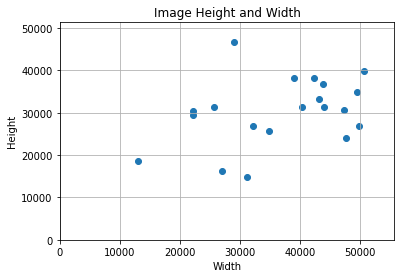

In [25]:
#The size of the images varies greatly as well.
plt.scatter(df_info['width_pixels'], df_info['height_pixels'])
plt.title('Image Height and Width')
plt.xlabel('Width')
plt.ylabel('Height')
plt.xlim(0, df_info['width_pixels'].max() * 1.1)
plt.ylim(0, df_info['height_pixels'].max() * 1.1)
plt.grid()

In [26]:
def overlay_image_mask(image, mask, mask_color=(0,255,0), alpha=1.0):
    im_f= image.astype(np.float32)
#     if mask.ndim == 2:
#         mask = np.expand_dims(mask,-1)        
    mask_col = np.expand_dims(np.array(mask_color)/255.0, axis=(0,1))
    return (im_f + alpha * mask * (np.mean(0.8 * im_f + 0.2 * 255, axis=2, keepdims=True) * mask_col - im_f)).astype(np.uint8)


def overlay_image_mask_original(image, mask, mask_color=(0,255,0), alpha=1.0):
    return  np.concatenate((image, overlay_image_mask(image, mask)), axis=1)

def get_image_id(image_file):
    return os.path.splitext(os.path.split(image_file)[1])[0]


def read_image(image_file, scale=1.0):
    image = tifffile.imread(image_file).squeeze()
    if image.shape[0] == 3:
        image = np.transpose(image, (1,2,0))
    
    orig_shape = image.shape
    if scale != 1.0:
        image = cv2.resize(image, (0,0), fx=scale, fy=scale)
    return image, orig_shape


def read_mask(image_file, image_shape, scale=1.0):
    image_id = get_image_id(image_file)
    train_info = df_train.loc[df_train['id'] == image_id]
    rle = train_info['encoding'].values[0] if len(train_info) > 0 else None
    if rle is not None:
        mask = rle_to_image(rle, (image_shape[1], image_shape[0]))
        if scale != 1.0:
            mask = cv2.resize(mask, (0,0), fx=scale, fy=scale)
        return np.expand_dims(mask,-1)
    else:
        return None        

    
def read_image_mask(image_file, scale=1.0):
    image, image_shape = read_image(image_file, scale)
    mask = read_mask(image_file, image_shape, scale)
    return image, mask


def get_tile(image, mask, x, y, tile_size, scale=1.0):
    x = round(x * scale)
    y = round(y * scale)
    size = int(round(tile_size / 2 * scale))
    image_s = image[y-size:y+size, x-size:x+size, :] 
    mask_s = mask[y-size:y+size, x-size:x+size, :]
    return image_s, mask_s


def get_particles(mask, scale=1.0):
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    df_particles = pd.DataFrame(dict(zip(['x','y','left','top','width','height','area'],
                               [(centroids[1:,0]) / scale,
                                (centroids[1:,1]) / scale,
                                (stats[1:,cv2.CC_STAT_LEFT]) / scale,
                                (stats[1:,cv2.CC_STAT_TOP]) / scale,
                                (stats[1:,cv2.CC_STAT_WIDTH]) / scale,
                                (stats[1:,cv2.CC_STAT_HEIGHT]) / scale,
                                (stats[1:,cv2.CC_STAT_AREA]) / (scale * scale)])))
    df_particles.sort_values(['x','y'], inplace=True, ignore_index=True)
    df_particles['no'] = range(len(df_particles))
    return df_particles


def analyze_image(image_file):
    image_id = get_image_id(image_file)
    image, image_shape = read_image(image_file, glob_scale)
    mask = read_mask(image_file, image_shape, glob_scale)

    mask_full = read_mask(image_file, image_shape, scale=1.0)
    df_glom = get_particles(mask_full, scale=1.0)
    df_glom['id'] = image_id
    del mask_full
    gc.collect()
    
    info = df_info[df_info['image_file'] == f'{image_id}.tiff']
    print(f'Image ID:        {image_id:}')
    print(f'Image Size:      {info["width_pixels"].values[0]} x {info["height_pixels"].values[0]}')
    print(f'Patient No:      {info["patient_number"].values[0]}')
    print(f'Sex:             {info["sex"].values[0]}')
    print(f'Age:             {info["age"].values[0]}')
    print(f'Race:            {info["race"].values[0]}')
    print(f'Height:          {info["height_centimeters"].values[0]} cm')
    print(f'Weight:          {info["weight_kilograms"].values[0]} kg')
    print(f'BMI:             {info["bmi_kg/m^2"].values[0]} kg/m^2')
    print(f'Laterality:      {info["laterality"].values[0]}')
    print(f'Percent Cortex:  {info["percent_cortex"].values[0]} %')
    print(f'Percent Medulla: {info["percent_medulla"].values[0]} %')
    
    # Plot full image
    if plot_full_image:
        scale = 0.1
        image_small = cv2.resize(image, (0,0), fx=scale, fy=scale)
        mask_small = cv2.resize(mask, (0,0), fx=scale, fy=scale)
        mask_small = np.expand_dims(mask_small,-1) 
    
        plt.figure(figsize=(16, 16))
        plt.imshow(overlay_image_mask(image_small, mask_small))
        plt.axis('off')

    # Plot glomeruli images
    fig_cols = 5
    fig_rows = int(math.ceil(num_glom_display/fig_cols))
    plt.figure(figsize=(4 * fig_cols, 4 * fig_rows))
    if num_glom_save > 0 and not os.path.exists(image_id):
        os.mkdir(image_id)
    for i in range(min(max(num_glom_display, num_glom_save), len(df_glom))):
        image_s, mask_s = get_tile(image,mask, df_glom['x'][i], df_glom['y'][i], 1000, scale=glob_scale)
        ovl = overlay_image_mask(image_s, mask_s)
        if i < num_glom_display:
            plt.subplot(fig_rows, fig_cols, i+1)
            plt.imshow(ovl)
            plt.axis('off')
        if i < num_glom_save:
            cv2.imwrite(f'{image_id}_{i:03}.png', cv2.cvtColor(ovl, cv2.COLOR_RGB2BGR))    
    
    del image, mask
    gc.collect()
    return df_glom


def plot_glom(df, image_id, glom_no):
    image, mask = read_image_mask(os.path.join(base_path, f'train/{image_id}.tiff'), scale=glob_scale)
    glom = df.loc[(df['id'] == image_id) & (df['no'] == glom_no)]
    im, ma = get_tile(image, mask, glom['x'].iloc[0], glom['y'].iloc[0], 1000, scale=glob_scale)
    del image, mask
    gc.collect()
    plt.figure(figsize=(16,8))
    plt.imshow(overlay_image_mask_original(im, ma))
    plt.title(f'Image: {image_id}, Glomeruli No: {glom_no}, Area: {glom["area"].iloc[0]}')

Image ID:        0486052bb
Image Size:      34937 x 25784
Patient No:      67177
Sex:             Male
Age:             31
Race:            White
Height:          180.3 cm
Weight:          106.1 kg
BMI:             32.6 kg/m^2
Laterality:      Right
Percent Cortex:  80 %
Percent Medulla: 20 %


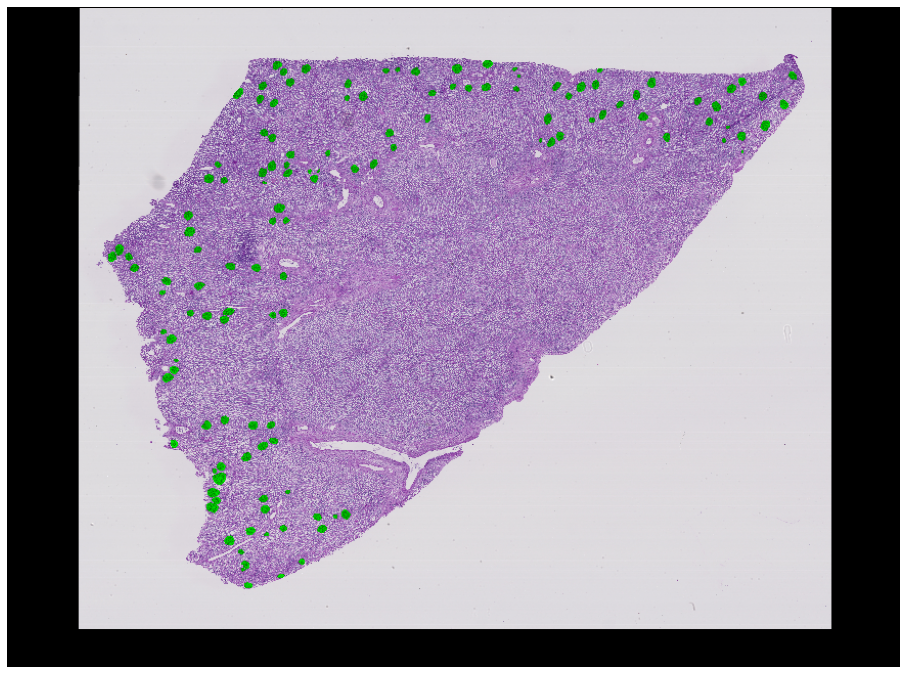

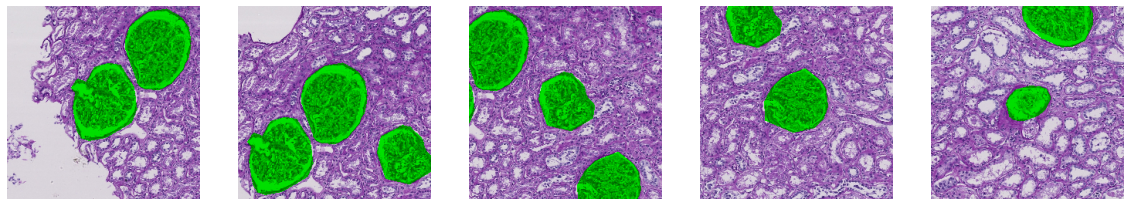

In [27]:
df_glom = pd.DataFrame()
df_glom = df_glom.append(analyze_image(train_files[0]), ignore_index=True)

In [ ]:
df_glom = df_glom.append(analyze_image(train_files[1]), ignore_index=True)